# 1. Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

In [2]:
import cellpose
from cellpose import models

In [3]:
from tqdm import tqdm

# 2. Define data parameters

In [4]:
# Common parameters for loading the image files of interest

# for 4 channels nd2 images: channel index order is 1-2-3-4, which is the order as ch405-ch488-ch560-ch647


# analysis done
num_of_ch = 2

# Replace protein/dna label name in the "xxx" below for the indicated channel index (make sure the order is correct)
# For example: ch_dict = {"dna":1,"rpa/rpa2":2,"mdc1":3,"pol2S5":4} if rpa/rpa2 was used for ch488
# Make sure the label name is the same as the factor/dna key used in the line below
ch_dict = {"dna":1,"Mdc1":2}

# If use mdc1 as the factor for region segementation
# If use dna/dapi as the key channel for nucleus segmentation
mdc1_key =  "Mdc1"
dna_key = 'dna'  # temporary fix since DNA is not good
other_key="other"

# Whether to analyze the sub-area masks defined by the second marker within the first marker (e.g., h2ax within the mdc) 
analyze_ch_for_2nd_marker_dict = {1:True,2:True,3:False}

# Replace the data directory in the ""; * is the final path level where images are located
# For example: data_save_folder = r"F:\XXX\AAA\BBB\*"

# define well here
# candidate wells: 3, 4, 5, 6, 7
#well_name = 'well3' # done
#well_name = 'well4' #done
#well_name = 'well5' #done
#well_name = 'well6' #done
#well_name = 'well7' #done


############################# CHANGE WELL FOR DATA OF INTEREST ABVOE!##########################################

############################# CHANGE WELL FOR DATA OF INTEREST BELOW!##########################################
data_output_folder = r"D:\Analyzed_CellBio\Stam\40x_MNbody_analysis\220331IF_210217exp_p53ko_fixed\p53ko_8days\40x"
data_main_folder =os.path.join(data_output_folder, '*')
############################# CHANGE WELL FOR DATA OF INTEREST HERE!##########################################



data_input_folder = data_main_folder
data_files = [file for file in glob.glob(data_input_folder) if file[-3:]=="nd2"]

data_files

['D:\\Analyzed_CellBio\\Stam\\40x_MNbody_analysis\\220331IF_210217exp_p53ko_fixed\\p53ko_8days\\40x\\RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-647_010.nd2']

In [6]:
# analyze all ND file or not
# also used as bool setting for adjusting code indendation between different pipelines
_analyze_all_nd = True
#_analyze_all_nd = True

# print progress
_verbose = True

# bad fovs to exclude (e.g., out of focus nd file) if analyze all nd file
# {nd_file_index : [fov_indexes]}
if _analyze_all_nd:
    #fov_to_exclude_dict = {1:[4,5],5:[2,3]}
    fov_to_exclude_dict = {1:[16]}
    

# The pixel size for excluding small 53BP_body;
# Replace *300* with other number desired or *0* if do not want to perform 53BP1 body foci exclusion durng analysis
# Desired foci exclusion can still be performed post-hoc in the resulting dataframe after analysis
# use 200 for 40x images
small_53BP_size = 200

# Other parameteres for image analysis
# border pixel removal for h2ax (or other markers within sub-mdc1 area) positive or less-positive area
h2ax_border_size_filter = 1

# aproximate size for each cell (nuclei)
nuclei_filter = 1000

# for removing tiny nucleoli areas
small_nucleoli_dirt = 10

# erosion factor for dna segmenation
erosion_factor_dna = 5


# std ratio for positive mdc or h2ax, etc calling
h2ax_std_ratio = 3
mdc_std_ratio = 2

# if analyze cell of interest based on annotation:
# the approx distance radius range between the given center and the segmenated center
coord_dist = 100
# if if perform image cropping covering the cell of interest or not
crop_image =  True
raw_image_size = [2048,2048]

# if adjust the focal plane using a smaller crop range than the range used for actual analysis (aka cell size)
narrow_adjust = True
# define the narrowed ratio of the initial crop
narrow_ratio = 0.1


# if re-adjust the focal plane based on cell of interest
adjust_z_for_cell = False


# the cropped image size if performing image cropping covering the cell of interest
cell_size =400

# the percentile for Pol2 to segment the nucleoli area
po2_neg_percentile = 10

# use DAPI channel to do nuclei segmentation or not
use_dna_nuclei = True # shall be good since local dapi in the center is okay

# the alternative channel key if using other channel for nuclei segmentation
if not use_dna_nuclei:
    dna_key = pol2_key
    
    
# specify the region from the whole fov where analysis would be performed
search_xylim = [0,2048]  # Note that DNA channel from the data often is not evenly illuminated


# if save the cropped raw images or not
save_crop_raw_image = True



# 3. Analyze data

In [7]:
# Initiate result dataframe to store analysis measurement:
measurement_for_all_fov_df = pd.DataFrame()


# Initiate cellpose model
model= models.Cellpose(gpu=False, model_type='nuclei',)
####################################################################################
# Loop through each ND data file
for data_ind, data in enumerate(data_files[:]):

    # data name: usually the experiment name 
    data_name = data.split('\\')[-1]

    # if use annotation, then check if data/exp name is in the annotation dict
    if not _analyze_all_nd:
        if data_name in cell_info_dict.keys():
            if _verbose:
                print(f"-----------------------------------------------------------")    
                print(f"-- Start analyzing the dataset of {data_name}")
            # load data if ND data exists in the anntation
            images = ND2Reader(data)
            num_of_planes = images.sizes["z"] # load 'z' info
            # multi-fov image
            if 'v' in images.sizes.keys():
                num_of_fov = images.sizes["v"] # load 'v' info
            # set num_of_fov as 1 for single fov image
            else:
                num_of_fov = 1
        
            # load fov_of_interest from the preprocessed cell_info_dict
            fov_of_interest_str = cell_info_dict[data_name].keys()
            fov_of_interest = [(int(_fov_str)-1) for _fov_str in fov_of_interest_str]
            #print(fov_of_interest)
        else:
            fov_of_interest = []
                    
    # load data without using annotation
    else:
        images = ND2Reader(data)
        num_of_planes = images.sizes["z"] # load 'z' info
        # multi-fov image
        if 'v' in images.sizes.keys():
            num_of_fov = images.sizes["v"] # load 'v' info
        # set num_of_fov as 1 for single fov image
        else:
            num_of_fov = 1
            
        # if exclude bad focal plane that are not focused
        fovs_all = list(range(num_of_fov))
        if data_ind in fov_to_exclude_dict.keys():
            fov_of_interest = [ind for ind in fovs_all if ind not in fov_to_exclude_dict[data_ind]]
        else:
            fov_of_interest = fovs_all
            
###########################################################################################
# Loop through each FOV of interest
    if _verbose:# for indentation purposes
        
        for _fov_id in tqdm(fov_of_interest[:]):                
            
            # use annotation dict to look for cell of interest
            if not _analyze_all_nd:
                if _verbose:
                    print ('-- Use given annotation dict to find cells.')
                cell_coord_list = cell_info_dict[data_name][str(_fov_id+1)] 
            
            # use 3D nuclei signal to do segmenation by cellpose
            else:
                if _verbose:
                    print ('-- Generate 3D nuclei segmentation to find cells.')
                image_cell_3d = []
                for _lyr in range(num_of_planes): # ch index starts from 0
                    image_cell = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[dna_key]-1, z=_lyr))
                    image_cell_3d.append(image_cell)
                image_cell_3d = np.array(image_cell_3d)
                #
                nuclei_mask_3d,flows, styles, diams = model.eval(image_cell_3d, diameter=90, 
                                                    channels = [0,0],
                                                   flow_threshold=1, do_3D=False)
                
                noncell_mask_all = nuclei_mask_3d==0
                
                # remove edge cell
                nuclei_mask_3d=cellpose.utils.remove_edge_masks(nuclei_mask_3d, change_index=True)
                nuclei_mask_3d=cellpose.utils.fill_holes_and_remove_small_masks(nuclei_mask_3d, min_size=nuclei_filter)
                
                mask_save_path = data_output_folder + os.sep + f'segmentations_{mdc_std_ratio}_{small_53BP_size}_crop_subset_controlled' +  os.sep + \
                        f'{data_name}' +os.sep + f'_Pos_{_fov_id+1}'
                if not os.path.exists(mask_save_path):
                    os.makedirs(mask_save_path)
                mask_name = f'Nuclei_segmenations_exclude_edges_Pos_{_fov_id+1}.tif'
                if os.path.exists(mask_save_path+os.sep+mask_name):
                    os.remove(mask_save_path+os.sep+mask_name)
                io.imsave(mask_save_path+os.sep+mask_name,(skimage.img_as_ubyte(nuclei_mask_3d)), check_contrast=False)
                
                #print(num_of_nuclei)
                # if use the cell coord refined analysis
                cell_coord_list  = []
                for i in np.unique(nuclei_mask_3d)[:]:
                    if i >0:
                        # initate dict to store result
                        measurement_each_dict = {}
                        _cell_id=i
                        cand_nucleus = nuclei_mask_3d == i
                        cand_nucleus[cand_nucleus>0]=1
                        cand_nucleus = np.array(cand_nucleus)
                        # append the coord for the objects of interest
                        region = skimage.measure.regionprops (skimage.measure.label(cand_nucleus))[0]
                        # centroid coord as YX, select the cells within the predefined bound
                        check_Y_pos = region.centroid[0] >= search_xylim[0] and region.centroid[0] <= search_xylim[1]
                        check_X_pos = region.centroid[1] >= search_xylim[0] and region.centroid[1] <= search_xylim[1]
                        if check_Y_pos and check_X_pos:
                            cell_center = [int(region.centroid[1]),int(region.centroid[0])]
                            cell_coord_list.append(cell_center)
                            if _verbose:
                                print (f'-- Processing Cell#{_cell_id} from the image')

                            # define as nuclei mask
                            nuclei_to_measure = cand_nucleus
                            noncell_background = noncell_mask_all

                            # Find the best focal plane using the m6T/mdc (the factor key) channel for the cell of interest  
                            #image_fl = []
                            image_std = []
                            image_3d_for_label = []

                            for _lyr in range(num_of_planes): # ch index starts from 0
                                image_array_fl = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=_lyr))                  
                                # do cropping if necessary; remember to inver XY
                                if crop_image: # current crop size as rough cell size
                                    crop_y1 = int(max(0,cell_center[1]-cell_size/2))
                                    crop_y2 = int(min(raw_image_size[1],cell_center[1]+cell_size/2))
                                    crop_x1 = int(max(0,cell_center[0]-cell_size/2))
                                    crop_x2 = int(min(raw_image_size[0],cell_center[0]+cell_size/2))
                                    image_array_fl = image_array_fl[crop_y1:crop_y2,crop_x1:crop_x2]


                                 # use image signal STD distribution to find the best focal plane for the plane of interest
                                _fl=image_array_fl.flatten()
                                image_std.append(np.std(_fl))
                                #also append the image for later potential usage (eg. re-adjust focal plane)
                                #image_3d_for_label.append(image_array_fl)

                            # find the initial best focal plane using std features          
                            best_plane_index = np.argmax(np.array(image_std))
                            if _verbose:
                                print(f"-- Analyzing the plane {best_plane_index+1} in fov {_fov_id+1}.")
                            sel_img = np.array(images.get_frame_2D (v=_fov_id, c= ch_dict[mdc1_key]-1, z=best_plane_index))                  

                            if crop_image: # current crop size as rough cell size
                                sel_img = sel_img[crop_y1:crop_y2,crop_x1:crop_x2]
                                nuclei_to_measure = nuclei_to_measure[crop_y1:crop_y2,crop_x1:crop_x2]
                                noncell_background = noncell_background[crop_y1:crop_y2,crop_x1:crop_x2]


                            # Get cellular mdc mask 
                            mdc_intensity = sel_img*nuclei_to_measure
                            mdc_intensity_filtered = mdc_intensity[mdc_intensity!=0]
                            mdc_positive_th =np.mean(mdc_intensity_filtered) + np.std(mdc_intensity_filtered)*mdc_std_ratio
                            mdc_mask = np.logical_and(sel_img>mdc_positive_th, nuclei_to_measure)
                            mdc_chr_mask = remove_small_objects(mdc_mask, small_53BP_size,connectivity=1)
                            mdc_chr_mask = ndi.binary_fill_holes(mdc_chr_mask)
                            mdc_chr_mask = dilation(mdc_chr_mask,disk(1))
                            mdc_chr_mask = erosion(mdc_chr_mask,disk(1))

                            # Append info and results for cells of interest
                            measurement_each_dict['exp_name']=data_input_folder.split('\\')[-2]
                            measurement_each_dict['position_id']=f'{data_name}_Pos{_fov_id+1}'
                            measurement_each_dict['cell_id']=int(_cell_id+1)
                            measurement_each_dict['cell_xyz_coord']=[cell_center, best_plane_index+1]

                            measurement_each_dict['mdc1_size']=np.sum(mdc_chr_mask)
                            measurement_each_dict['nucleus_size']=np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_relative_size']=np.sum(mdc_chr_mask)/np.sum(nuclei_to_measure)
                            measurement_each_dict['mdc1_mdc1_intensity']=np.mean((sel_img * mdc_chr_mask)[mdc_chr_mask!=0])
                            measurement_each_dict['nucleus_mdc1_intensity']=np.mean((sel_img * nuclei_to_measure)[nuclei_to_measure!=0])
                            measurement_each_dict['noncell_mdc1_intensity']=np.mean((sel_img * noncell_background)[noncell_background!=0])
                            measurement_each_dict['mdc1_mdc1_norm_intensity']=((measurement_each_dict['mdc1_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity'])
                                                                               /(measurement_each_dict['nucleus_mdc1_intensity']-measurement_each_dict['noncell_mdc1_intensity']))


                            measurement_for_each_cell_df=pd.DataFrame.from_dict(measurement_each_dict,orient='index').transpose()
                            measurement_for_all_fov_df = pd.concat([measurement_for_all_fov_df,measurement_for_each_cell_df])

                            # Save individual valid mask or image for each cell 
                            mask_file_list = [mdc_chr_mask,nuclei_to_measure,sel_img]
                            mask_savename_list = [f'cell_{_cell_id+1}_cand_MN_body.tif',
                                                  f'cell_{_cell_id+1}_nucleus.tif',
                                                  f'cell_{_cell_id+1}_MDC1_image.tif',]

                            for _name, _file in zip(mask_savename_list,mask_file_list):
                                # remove old ones if exist
                                if os.path.exists(mask_save_path+os.sep+_name):
                                    os.remove(mask_save_path+os.sep+_name)
                                if _name == f'cell_{_cell_id+1}_MDC1_image.tif':
                                    if save_crop_raw_image:
                                        io.imsave(mask_save_path+os.sep+_name,_file, check_contrast=False)
                                    else:
                                        pass
                                else:
                                    io.imsave(mask_save_path+os.sep+_name,(skimage.img_as_ubyte(_file)), check_contrast=False)



                                
# Save excel result
_save_results = True

if _save_results:
    analysis_savename = f'measurement_for_all_fov_background_subtracted_{mdc_std_ratio}_{small_53BP_size}_crop.xlsx'
    #analysis_save_path = data_save_folder[:-2] + os.sep + 'analysis' + os.sep + f'{data_name}' 
    analysis_save_path = data_output_folder + os.sep + 'analysis_subset_controlled' 
    if not os.path.exists(analysis_save_path):
        os.makedirs(analysis_save_path)
    measurement_for_all_fov_df.to_excel(analysis_save_path+os.sep+analysis_savename)
                            
                        

  0%|                                                                                           | 0/70 [00:00<?, ?it/s]

-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 15 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 1.
-- Processing Cell#2 from the image


c:\programdata\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


-- Analyzing the plane 8 in fov 1.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 1.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 1.
-- Processing Cell#15 from the image


  1%|█▏                                                                                 | 1/70 [00:30<34:46, 30.24s/it]

-- Analyzing the plane 7 in fov 1.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 7 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 2.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 2.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 2.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 2.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 2.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 2.
-- Processing Cell#7 from the image


  3%|██▎                                                                                | 2/70 [00:53<29:18, 25.85s/it]

-- Analyzing the plane 5 in fov 2.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 46 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 3.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 3.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 3.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 3.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#13 from the image
-- Analyzing the plane 8 in fov 3.
-- Processing Cell#14 from the image
-- Analyzing the plane 8 in fov 3.
-

  4%|███▌                                                                               | 3/70 [01:51<45:40, 40.90s/it]

-- Analyzing the plane 7 in fov 3.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 4.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 4.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 4.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 4.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 4.
-- Processing Cell#13 from the image
-- Analyzing the plane 

  6%|████▋                                                                              | 4/70 [02:23<41:02, 37.30s/it]

-- Analyzing the plane 4 in fov 4.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 17 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 5.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 5.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 5.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 5.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 5.
-

  7%|█████▉                                                                             | 5/70 [02:55<38:15, 35.32s/it]

-- Analyzing the plane 6 in fov 5.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 55 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 6.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 6.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 6.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 6.
-

  9%|███████                                                                            | 6/70 [04:04<49:59, 46.87s/it]

-- Analyzing the plane 6 in fov 6.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 45 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 7.
-- Processing Cell#13 from the image
-- Analyzing the plane 8 in fov 7.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 7.
-

 10%|████████▎                                                                          | 7/70 [05:07<54:30, 51.92s/it]

-- Analyzing the plane 7 in fov 7.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 40 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 8.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 8.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 8.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 8.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 8.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 8.
-- Processing Cell#13 from the image
-- Analyzing the plane 6 in fov 8.
-- Processing Cell#14 from the image
-- Analyzing the plane 7 in fov 8.
-

 11%|█████████▍                                                                         | 8/70 [06:01<54:30, 52.75s/it]

-- Analyzing the plane 5 in fov 8.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 88 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 9.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#13 from the image
-- Analyzing the plane 9 in fov 9.
-- Processing Cell#14 from the image
-- Analyzing the plane 9 in fov 9.
-

 13%|██████████▍                                                                      | 9/70 [07:41<1:08:38, 67.51s/it]

-- Analyzing the plane 7 in fov 9.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 99 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#13 from the image
-- Analyzing the plane 9 in fov 10.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 14%|███████████▍                                                                    | 10/70 [09:31<1:20:42, 80.70s/it]

-- Analyzing the plane 8 in fov 10.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 112 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 11.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 16%|████████████▌                                                                   | 11/70 [11:35<1:32:25, 93.98s/it]

-- Analyzing the plane 6 in fov 11.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 62 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 12.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 12.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 12.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 12.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 12.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 12.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 12.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 12.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 12.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 12.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 12.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 12.
-- Processing Cell#13 from the image
-- Analyzing the plane 8 in fov 12.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 17%|█████████████▋                                                                  | 12/70 [12:50<1:25:04, 88.00s/it]

-- Analyzing the plane 7 in fov 12.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 70 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 13.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 13.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 13.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 13.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 19%|██████████████▊                                                                 | 13/70 [14:14<1:22:28, 86.82s/it]

-- Analyzing the plane 6 in fov 13.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 65 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 14.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 14.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 14.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 14.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 20%|████████████████                                                                | 14/70 [15:31<1:18:25, 84.02s/it]

-- Analyzing the plane 6 in fov 14.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 29 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 15.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 15.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 15.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 15.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 21%|█████████████████▏                                                              | 15/70 [16:11<1:04:51, 70.76s/it]

-- Analyzing the plane 6 in fov 15.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 18 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 16.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 16.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 23%|██████████████████▋                                                               | 16/70 [16:43<53:01, 58.91s/it]

-- Analyzing the plane 5 in fov 16.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 12 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 17.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 17.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 17.
-- Processing Cell#12 from the image


 24%|███████████████████▉                                                              | 17/70 [17:10<43:37, 49.39s/it]

-- Analyzing the plane 7 in fov 17.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 20 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 18.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 18.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 26%|█████████████████████                                                             | 18/70 [17:44<38:47, 44.76s/it]

-- Analyzing the plane 7 in fov 18.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 6 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 19.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 19.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 19.
-- Processing Cell#6 from the image


 27%|██████████████████████▎                                                           | 19/70 [18:07<32:25, 38.15s/it]

-- Analyzing the plane 7 in fov 19.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 13 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 20.
-- Processing Cell#13 from the image


 29%|███████████████████████▍                                                          | 20/70 [18:35<29:23, 35.27s/it]

-- Analyzing the plane 6 in fov 20.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 19 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 21.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#13 from the image
-- Analyzing the plane 9 in fov 21.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 30%|████████████████████████▌                                                         | 21/70 [19:09<28:20, 34.70s/it]

-- Analyzing the plane 8 in fov 21.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 22.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 22.
-- Processing Cell#13 from the image
-- Analyzi

 31%|█████████████████████████▊                                                        | 22/70 [19:44<27:49, 34.79s/it]

-- Analyzing the plane 7 in fov 22.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 23.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 23.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 23.
-- Processing Cell#13 from the image
-- Analyzi

 33%|██████████████████████████▉                                                       | 23/70 [20:16<26:42, 34.10s/it]

-- Analyzing the plane 8 in fov 23.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 11 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 24.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 24.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 24.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 24.
-- Processing Cell#11 from the image


 34%|████████████████████████████                                                      | 24/70 [20:45<24:53, 32.47s/it]

-- Analyzing the plane 6 in fov 24.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 9 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 25.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 25.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 25.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 25.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 25.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 25.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 25.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 25.
-- Processing Cell#9 from the image


 36%|█████████████████████████████▎                                                    | 25/70 [21:11<22:59, 30.66s/it]

-- Analyzing the plane 7 in fov 25.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 26.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 26.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 26.
-- Processing Cell#13 from the image


 37%|██████████████████████████████▍                                                   | 26/70 [21:40<22:02, 30.06s/it]

-- Analyzing the plane 8 in fov 26.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 8 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 27.
-- Processing Cell#8 from the image


 39%|███████████████████████████████▋                                                  | 27/70 [22:05<20:34, 28.72s/it]

-- Analyzing the plane 5 in fov 27.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 28.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 28.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 28.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 28.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 28.
-- Processing Cell#13 from the image
-- Analyzi

 40%|████████████████████████████████▊                                                 | 28/70 [22:41<21:30, 30.72s/it]

-- Analyzing the plane 6 in fov 28.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 29.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 29.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 29.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 29.
-- Processing Cell#13 from the image
-- Analyzi

 41%|█████████████████████████████████▉                                                | 29/70 [23:17<22:01, 32.23s/it]

-- Analyzing the plane 7 in fov 29.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 30.
-- Processing Cell#13 from the image
-- Analyzi

 43%|███████████████████████████████████▏                                              | 30/70 [23:50<21:39, 32.49s/it]

-- Analyzing the plane 7 in fov 30.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 23 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 31.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 31.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 31.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 31.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 31.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 44%|████████████████████████████████████▎                                             | 31/70 [24:26<21:56, 33.76s/it]

-- Analyzing the plane 6 in fov 31.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 32.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 32.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 32.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 32.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 32.
-- Processing Cell#13 from the image
-- Analyzi

 46%|█████████████████████████████████████▍                                            | 32/70 [25:00<21:19, 33.68s/it]

-- Analyzing the plane 5 in fov 32.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 33.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 33.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 33.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 33.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 33.
-- Processing Cell#13 from the image


 47%|██████████████████████████████████████▋                                           | 33/70 [25:30<20:03, 32.53s/it]

-- Analyzing the plane 8 in fov 33.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 32 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 34.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#13 from the image
-- Analyzing the plane 9 in fov 34.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 49%|███████████████████████████████████████▊                                          | 34/70 [26:14<21:42, 36.18s/it]

-- Analyzing the plane 8 in fov 34.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 35.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 35.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 35.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 35.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 35.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 35.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 35.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 35.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 35.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 35.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 35.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 35.
-- Processing Cell#13 from the image
-- Analyzi

 50%|█████████████████████████████████████████                                         | 35/70 [26:53<21:27, 36.79s/it]

-- Analyzing the plane 8 in fov 35.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 49 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 36.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 36.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#13 from the image
-- Analyzing the plane 8 in fov 36.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 51%|██████████████████████████████████████████▏                                       | 36/70 [27:58<25:45, 45.44s/it]

-- Analyzing the plane 7 in fov 36.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 37 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 37.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 37.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 53%|███████████████████████████████████████████▎                                      | 37/70 [28:48<25:41, 46.70s/it]

-- Analyzing the plane 6 in fov 37.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 38.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 38.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 38.
-- Processing Cell#13 from the image
-- Analyzi

 54%|████████████████████████████████████████████▌                                     | 38/70 [29:22<22:52, 42.89s/it]

-- Analyzing the plane 7 in fov 38.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 39.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 39.
-- Processing Cell#13 from the image


 56%|█████████████████████████████████████████████▋                                    | 39/70 [29:51<19:57, 38.62s/it]

-- Analyzing the plane 7 in fov 39.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 40.
-- Processing Cell#13 from the image
-- Analyzi

 57%|██████████████████████████████████████████████▊                                   | 40/70 [30:26<18:47, 37.59s/it]

-- Analyzing the plane 9 in fov 40.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 16 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#6 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#12 from the image
-- Analyzing the plane 6 in fov 41.
-- Processing Cell#13 from the image
-- Analyzing the plane 5 in fov 41.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 59%|████████████████████████████████████████████████                                  | 41/70 [30:57<17:13, 35.62s/it]

-- Analyzing the plane 5 in fov 41.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 42.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 42.
-- Processing Cell#13 from the image
-- Analyzi

 60%|█████████████████████████████████████████████████▏                                | 42/70 [31:32<16:34, 35.52s/it]

-- Analyzing the plane 7 in fov 42.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 43.
-- Processing Cell#13 from the image
-- Analyzi

 61%|██████████████████████████████████████████████████▎                               | 43/70 [32:03<15:21, 34.13s/it]

-- Analyzing the plane 8 in fov 43.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 26 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 44.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 44.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 44.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 44.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 44.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 44.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 44.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 44.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 44.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 44.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 44.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 44.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 44.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 63%|███████████████████████████████████████████████████▌                              | 44/70 [32:43<15:31, 35.84s/it]

-- Analyzing the plane 7 in fov 44.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 45.
-- Processing Cell#13 from the image
-- Analyzi

 64%|████████████████████████████████████████████████████▋                             | 45/70 [33:18<14:48, 35.53s/it]

-- Analyzing the plane 8 in fov 45.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 46.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 46.
-- Processing Cell#13 from the image
-- Analyzi

 66%|█████████████████████████████████████████████████████▉                            | 46/70 [33:50<13:53, 34.71s/it]

-- Analyzing the plane 8 in fov 46.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 47.
-- Processing Cell#13 from the image
-- Analyzi

 67%|███████████████████████████████████████████████████████                           | 47/70 [34:33<14:15, 37.20s/it]

-- Analyzing the plane 7 in fov 47.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 21 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#13 from the image
-- Analyzing the plane 9 in fov 48.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 69%|████████████████████████████████████████████████████████▏                         | 48/70 [35:09<13:28, 36.77s/it]

-- Analyzing the plane 8 in fov 48.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 14 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 49.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 49.
-- Processing Cell#14 from the image


 70%|█████████████████████████████████████████████████████████▍                        | 49/70 [35:38<12:04, 34.48s/it]

-- Analyzing the plane 7 in fov 49.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 50.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 50.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 50.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 50.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 50.
-- Processing Cell#13 from the image
-- Analyzi

 71%|██████████████████████████████████████████████████████████▌                       | 50/70 [36:13<11:27, 34.40s/it]

-- Analyzing the plane 7 in fov 50.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 25 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 51.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 51.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 51.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 51.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 51.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 51.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 51.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 51.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 51.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 51.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 51.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 51.
-- Processing Cell#13 from the image
-- Analyzing the plane 8 in fov 51.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 73%|███████████████████████████████████████████████████████████▋                      | 51/70 [36:51<11:15, 35.57s/it]

-- Analyzing the plane 7 in fov 51.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 52.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 52.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 52.
-- Processing Cell#13 from the image
-- Analyzi

 74%|████████████████████████████████████████████████████████████▉                     | 52/70 [37:22<10:14, 34.14s/it]

-- Analyzing the plane 7 in fov 52.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 53.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 53.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 53.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 53.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 53.
-- Processing Cell#13 from the image


 76%|██████████████████████████████████████████████████████████████                    | 53/70 [37:51<09:16, 32.74s/it]

-- Analyzing the plane 8 in fov 53.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 22 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 54.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 54.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 54.
-- Processing Cell#13 from the image
-- Analyzing the plane 9 in fov 54.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 77%|███████████████████████████████████████████████████████████████▎                  | 54/70 [38:28<09:05, 34.09s/it]

-- Analyzing the plane 9 in fov 54.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 55.
-- Processing Cell#8 from the image


 79%|████████████████████████████████████████████████████████████████▍                 | 55/70 [38:54<07:53, 31.57s/it]

-- Analyzing the plane 6 in fov 55.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#2 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 56.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 56.
-- Processing Cell#13 from the image
-- Analyzi

 80%|█████████████████████████████████████████████████████████████████▌                | 56/70 [39:28<07:31, 32.25s/it]

-- Analyzing the plane 6 in fov 56.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 10 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 57.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 57.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 57.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 57.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 57.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 57.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 57.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 57.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 57.
-- Processing Cell#10 from the image


 81%|██████████████████████████████████████████████████████████████████▊               | 57/70 [39:56<06:42, 30.96s/it]

-- Analyzing the plane 8 in fov 57.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 58.
-- Processing Cell#13 from the image
-- Analyzi

 83%|███████████████████████████████████████████████████████████████████▉              | 58/70 [40:40<06:59, 34.93s/it]

-- Analyzing the plane 9 in fov 58.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 59.
-- Processing Cell#13 from the image
-- Analyzi

 84%|█████████████████████████████████████████████████████████████████████             | 59/70 [41:29<07:11, 39.19s/it]

-- Analyzing the plane 9 in fov 59.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 60.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 60.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 60.
-- Processing Cell#13 from the image
-- Analyzi

 86%|██████████████████████████████████████████████████████████████████████▎           | 60/70 [42:13<06:44, 40.49s/it]

-- Analyzing the plane 8 in fov 60.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#3 from the image
-- Analyzing the plane 7 in fov 61.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 61.
-- Processing Cell#5 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 61.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 61.
-- Processing Cell#9 from the image


 87%|███████████████████████████████████████████████████████████████████████▍          | 61/70 [42:39<05:25, 36.21s/it]

-- Analyzing the plane 6 in fov 61.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 31 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 62.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 62.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 62.
-- Processing Cell#4 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#5 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#6 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#7 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#8 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#9 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#10 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#11 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#12 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#13 from the image
-- Analyzing the plane 7 in fov 62.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 89%|████████████████████████████████████████████████████████████████████████▋         | 62/70 [43:21<05:03, 37.89s/it]

-- Analyzing the plane 7 in fov 62.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 34 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 63.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 63.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 63.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 63.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 63.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#13 from the image
-- Analyzing the plane 8 in fov 63.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 90%|█████████████████████████████████████████████████████████████████████████▊        | 63/70 [44:09<04:46, 40.91s/it]

-- Analyzing the plane 8 in fov 63.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#2 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#3 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#4 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#5 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#6 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#7 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#8 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#9 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#10 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#11 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#12 from the image
-- Analyzing the plane 8 in fov 64.
-- Processing Cell#13 from the image
-- Analyzi

 91%|██████████████████████████████████████████████████████████████████████████▉       | 64/70 [44:53<04:11, 41.85s/it]

-- Analyzing the plane 7 in fov 64.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 39 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#2 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#3 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#4 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#5 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#6 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#7 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#8 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#9 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#10 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#11 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#12 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#13 from the image
-- Analyzing the plane 9 in fov 65.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 93%|████████████████████████████████████████████████████████████████████████████▏     | 65/70 [45:41<03:39, 43.81s/it]

-- Analyzing the plane 8 in fov 65.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 35 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 66.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 66.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 66.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 66.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#13 from the image
-- Analyzing the plane 4 in fov 66.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 94%|█████████████████████████████████████████████████████████████████████████████▎    | 66/70 [46:29<03:00, 45.02s/it]

-- Analyzing the plane 3 in fov 66.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 67.
-- Processing Cell#2 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#3 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#4 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#7 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#8 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#9 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#10 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#11 from the image
-- Analyzing the plane 5 in fov 67.
-- Processing Cell#12 from the image


 96%|██████████████████████████████████████████████████████████████████████████████▍   | 67/70 [46:59<02:01, 40.38s/it]

-- Analyzing the plane 5 in fov 67.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#2 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#3 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#4 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#5 from the image
-- Analyzing the plane 5 in fov 68.
-- Processing Cell#6 from the image
-- Analyzing the plane 5 in fov 68.
-- Processing Cell#7 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#8 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#9 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#10 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#11 from the image
-- Analyzing the plane 6 in fov 68.
-- Processing Cell#12 from the image
-- Analyzing the plane 5 in fov 68.
-- Processing Cell#13 from the image
-- Analyzi

 97%|███████████████████████████████████████████████████████████████████████████████▋  | 68/70 [47:44<01:23, 41.86s/it]

-- Analyzing the plane 5 in fov 68.
-- Generate 3D nuclei segmentation to find cells.


C:\Users\Shiwei\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting int32 to uint8 without scaling because max value 36 fits in uint8
  return _convert(image, np.uint8, force_copy)


-- Processing Cell#1 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#5 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 69.
-- Processing Cell#8 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#9 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#10 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#11 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#12 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#13 from the image
-- Analyzing the plane 3 in fov 69.
-- Processing Cell#14 from the image
-- Analyzing the plane 

 99%|████████████████████████████████████████████████████████████████████████████████▊ | 69/70 [48:38<00:45, 45.53s/it]

-- Analyzing the plane 3 in fov 69.
-- Generate 3D nuclei segmentation to find cells.
-- Processing Cell#1 from the image
-- Analyzing the plane 5 in fov 70.
-- Processing Cell#2 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#3 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#4 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#5 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#6 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#7 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#8 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#9 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#10 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#11 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#12 from the image
-- Analyzing the plane 4 in fov 70.
-- Processing Cell#13 from the image
-- Analyzi

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [49:20<00:00, 42.30s/it]

-- Analyzing the plane 3 in fov 70.


In [8]:
measurement_for_all_fov_df

,exp_name,position_id,cell_id,cell_xyz_coord,mdc1_size,nucleus_size,mdc1_relative_size,mdc1_mdc1_intensity,nucleus_mdc1_intensity,noncell_mdc1_intensity,mdc1_mdc1_norm_intensity
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,2,"[[1454, 110], 8]",0,5638,0.0,NaN,286.862717,124.91939,NaN
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,3,"[[1534, 130], 8]",0,5481,0.0,NaN,279.293012,124.253072,NaN
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,4,"[[1302, 400], 7]",0,3571,0.0,NaN,280.208905,112.241336,NaN
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,5,"[[665, 513], 7]",0,2991,0.0,NaN,394.057172,115.434124,NaN
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,6,"[[1687, 561], 7]",0,3477,0.0,NaN,262.9652,111.912189,NaN
...,...,...,...,...,...,...,...,...,...,...,...
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,26,"[[1320, 999], 3]",0,1130,0.0,NaN,210.771681,146.146672,NaN
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,27,"[[1157, 1069], 4]",0,3035,0.0,NaN,347.547282,154.319615,NaN
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,28,"[[399, 1304], 3]",0,4582,0.0,NaN,385.876473,121.694231,NaN
0,40x,RPE1 p53ko noco 8d aMDC1-488 lamB1-561 PolS5-6...,29,"[[171, 1601], 3]",0,4544,0.0,NaN,290.042254,134.873717,NaN


In [9]:
import seaborn as sns

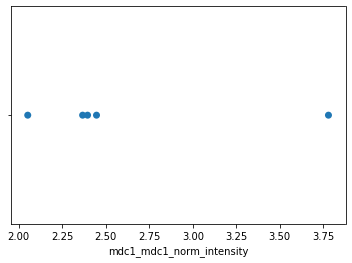

In [10]:
sns.swarmplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],s=7)

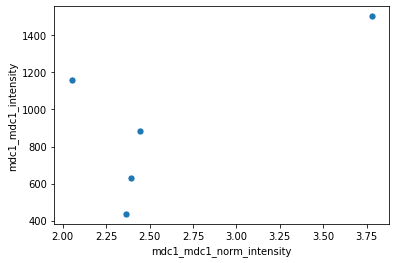

In [11]:
sns.scatterplot(measurement_for_all_fov_df['mdc1_mdc1_norm_intensity'],measurement_for_all_fov_df['mdc1_mdc1_intensity'],s=50)

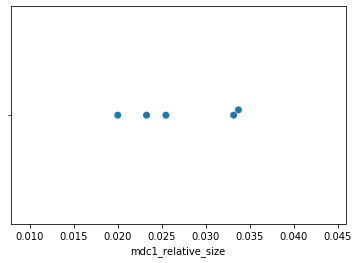

In [12]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_relative_size'],s=7)

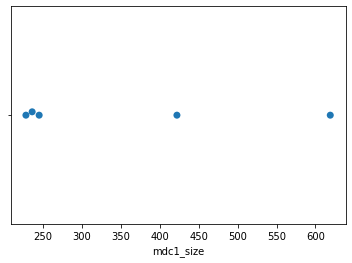

In [13]:
sel_mdc_df = measurement_for_all_fov_df[measurement_for_all_fov_df['mdc1_relative_size']>0]
sns.swarmplot(sel_mdc_df['mdc1_size'],s=7)

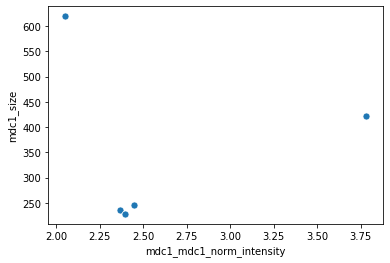

In [14]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_size'],s=50)

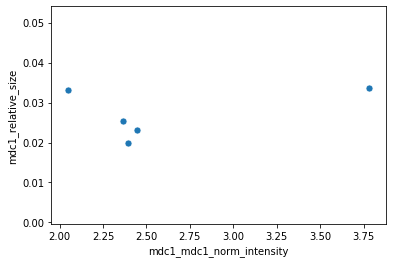

In [15]:
sns.scatterplot(sel_mdc_df['mdc1_mdc1_norm_intensity'],sel_mdc_df['mdc1_relative_size'],s=50)

In [16]:
measurement_for_all_fov_df_filter=measurement_for_all_fov_df[measurement_for_all_fov_df['nucleus_size']>2000]

In [17]:
len(measurement_for_all_fov_df_filter)

1855

In [18]:
len(measurement_for_all_fov_df)

1925

In [19]:
len(sel_mdc_df)

5

In [20]:
len(sel_mdc_df)/len(measurement_for_all_fov_df_filter)

0.0026954177897574125

In [21]:
len(sel_mdc_df)/len(measurement_for_all_fov_df)

0.0025974025974025974